# Preview - Article Coming Soon

# Step #1 Initialize Spark Session

In [1]:
# A tutorial for this file is available at www.relataly.com

# Import SparkSession from pyspark.sql
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType
from pyspark.sql.functions import col, isnan, when, count, udf, year, month, to_date, mean
import pyspark.sql.functions as F
import seaborn as sns
import matplotlib.pyplot as plt

# Create my_spark
spark = SparkSession.builder.getOrCreate()
print(spark)

# Step #2 Load the Weather Data

In [123]:
# Read File A
spark_weather_df_a = spark.read \
    .option("header", False) \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_a')

spark_weather_df_a.printSchema()
print(spark_weather_df_a.count())
spark_weather_df_a.limit(3).toPandas()

root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)
 |-- _c4: double (nullable = true)
 |-- _c5: double (nullable = true)
 |-- _c6: double (nullable = true)
 |-- _c7: double (nullable = true)
 |-- _c8: double (nullable = true)
 |-- _c9: string (nullable = true)

15384


,_c0,_c1,_c2,_c3,_c4,_c5,_c6,_c7,_c8,_c9
0,0,2020-01-01,-1.8,0.0,0.0,63.0,4.2,14.8,1034.6,None
1,1,2020-01-02,-1.3,0.0,0.0,196.0,2.8,11.1,1032.2,None
2,2,2020-01-03,2.8,0.9,0.0,226.0,7.6,27.8,1028.6,None


In [125]:
# Read File B
spark_weather_df_b = spark.read \
    .option("header", False) \
    .option("inferSchema", True) \
    .csv(path=f'data/weather/zurich_weather_b')

spark_weather_df_b.printSchema()
print(spark_weather_df_b.count())
spark_weather_df_b.limit(3).toPandas()


root
 |-- _c0: integer (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: double (nullable = true)

15383


,_c0,_c1,_c2,_c3
0,0,2005-01-01,6.8,1.5
1,1,2005-01-02,7.3,1.9
2,2,2005-01-03,4.3,0.7


# Step #3 Join the Data and Adjust Columns

In [101]:
# Drop unused Columns
spark_weather_df_a = spark_weather_df_a.drop("_c0")
spark_weather_df_b = spark_weather_df_b.drop("_c0")

In [102]:
# rename columns

# rename individual columns
spark_weather_df_b_renamed = spark_weather_df_b.withColumnRenamed("_c1", "date") \
    .withColumnRenamed("_c2", "max_temp") \
    .withColumnRenamed("_c3", "min_temp") 

        
#col("tavg"), col("prcp"), col("snow"), col("wdir"), col("wspd"), col("wpgt"), col("pres"), col("tsun")
        
# rename multiple columns at once   
def rename_multiple_columns(df, columns):
    if isinstance(columns, dict):
        return df.select(*[F.col(col_name).alias(columns.get(col_name, col_name)) for col_name in df.columns])
    else:
        raise ValueError("columns need to be in dict format {'existing_name_a':'new_name_a', 'existing_name_b':'new_name_b'}")

dict_columns = {"_c1": "date2", 
                "_c2": "avg_temp", 
                "_c3": "precipitation",
                "_c4": "snow",
                "_c5": "wind_direction",
                "_c6": "wind_speed",
                "_c7": "wind_power",
                "_c8": "air_pressure",
                "_c9": "sunny_hours",}
spark_weather_df_a_renamed = rename_multiple_columns(spark_weather_df_a , dict_columns)

In [103]:
# Join the dataframes
spark_weather_df = spark_weather_df_a_renamed.join(spark_weather_df_b_renamed, spark_weather_df_a_renamed.date2 == spark_weather_df_b_renamed.date, "inner")

# Step #4 Clean the Data

In [129]:
# Check for dublicates

# count dublicates
date_nulls = spark_weather_df.groupby(spark_weather_df.date) \
    .count() \
    .where('count > 1') \
    .sort(col("date")) \
    .limit(5)
print(date_nulls.toPandas())

# remove dublicates and drop column date2
spark_weather_df = spark_weather_df.dropDuplicates() \
    .drop(col("date2"))

Empty DataFrame
Columns: [date, count]
Index: []


In [105]:
# Sort the Data by Date
spark_weather_df = spark_weather_df.orderBy(spark_weather_df.date)

In [106]:
# Convert date to date datatype
spark_weather_df  = spark_weather_df \
.withColumn("date", to_date(col("date"),"yyyy-MM-dd")) \

# print schema
spark_weather_df.printSchema()

root
 |-- avg_temp: double (nullable = true)
 |-- precipitation: double (nullable = true)
 |-- snow: double (nullable = true)
 |-- wind_direction: double (nullable = true)
 |-- wind_speed: double (nullable = true)
 |-- wind_power: double (nullable = true)
 |-- air_pressure: double (nullable = true)
 |-- sunny_hours: string (nullable = true)
 |-- date: date (nullable = true)
 |-- max_temp: double (nullable = true)
 |-- min_temp: double (nullable = true)



In [107]:
# Filter the Data 
spark_weather_df = spark_weather_df.filter(spark_weather_df.avg_temp.isNotNull())

# Step #3 Gain a Quick Overview of the Data

In [108]:
# display the spark dataframe
spark_weather_df.limit(5).sort(col("date"), ascending=True).toPandas()

,avg_temp,precipitation,snow,wind_direction,wind_speed,wind_power,air_pressure,sunny_hours,date,max_temp,min_temp
0,-5.3,1.0,0.0,NaN,NaN,NaN,NaN,None,1979-01-01,-2.5,-12.2
1,-10.0,1.7,10.0,NaN,NaN,NaN,NaN,None,1979-01-02,-4.2,-12.2
2,-5.8,0.0,110.0,NaN,NaN,NaN,NaN,None,1979-01-03,-3.9,-7.9
3,-8.4,0.0,100.0,NaN,NaN,NaN,NaN,None,1979-01-04,-4.4,-10.5
4,-10.0,0.0,70.0,NaN,NaN,NaN,NaN,None,1979-01-05,-7.5,-11.2


In [109]:
# count null values
spark_weather_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in spark_weather_df.drop("date").columns]
   ).toPandas()

,avg_temp,precipitation,snow,wind_direction,wind_speed,wind_power,air_pressure,sunny_hours,max_temp,min_temp
0,0,0,140,14439,14427,14427,14427,15321,9,15


In [110]:
# describe the data
spark_weather_df.describe().toPandas()

# Alternatively to get the max value, we could use max_value = spark_weather_df.agg({"precipitation": "max"}).collect()[0][0]

,summary,avg_temp,precipitation,snow,wind_direction,wind_speed,wind_power,air_pressure,sunny_hours,max_temp,min_temp
0,count,15321,15321,15181,882,894,894,894,0,15312,15306
1,mean,9.575908883232168,3.040291103713834,7.904354126869113,156.8140589569161,7.343624161073823,27.526174496644327,1017.8562639821034,None,13.735403605015632,6.085744152619868
2,stddev,7.471143433345327,6.5301242011431215,31.349904991306115,96.6151281131892,4.903918795159273,16.10640039975966,8.201775128218522,None,8.821371609213703,6.615893120018267
3,min,-18.0,0.0,0.0,0.0,2.2,7.4,984.7,None,-15.2,-20.8
4,max,28.0,97.8,550.0,358.0,40.4,113.0,1042.8,None,36.0,22.5


# Step #4 Transform the Data using User Defined Functions (UDF)

In [111]:
# More Infos on User Defined Functions: https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/
# create bucket column for temperature
def binner(min_temp, max_temp):
        if (min_temp is None) or (max_temp is None):
            return "unknown"
        else:
            if min_temp < -10:
                return "freezing cold"
            elif min_temp < -5:
                return "very cold"
            elif min_temp < 0:
                return "cold"
            elif max_temp < 10:
                return "normal"
            elif max_temp < 20:
                return "warm"
            elif max_temp < 30:
                return "hot"
            elif max_temp >= 30:
                return "very hot"
        return "normal"


udf_binner_temp = udf(binner, StringType() )

spark_weather_df_ = spark_weather_df.withColumn("temp_buckets", udf_binner_temp(col("min_temp"), col("max_temp")))
spark_weather_df_.limit(10).toPandas()

,avg_temp,precipitation,snow,wind_direction,wind_speed,wind_power,air_pressure,sunny_hours,date,max_temp,min_temp,temp_buckets
0,-5.3,1.0,0.0,NaN,NaN,NaN,NaN,None,1979-01-01,-2.5,-12.2,freezing cold
1,-10.0,1.7,10.0,NaN,NaN,NaN,NaN,None,1979-01-02,-4.2,-12.2,freezing cold
2,-5.8,0.0,110.0,NaN,NaN,NaN,NaN,None,1979-01-03,-3.9,-7.9,very cold
3,-8.4,0.0,100.0,NaN,NaN,NaN,NaN,None,1979-01-04,-4.4,-10.5,freezing cold
4,-10.0,0.0,70.0,NaN,NaN,NaN,NaN,None,1979-01-05,-7.5,-11.2,freezing cold
5,-6.4,0.0,50.0,NaN,NaN,NaN,NaN,None,1979-01-06,-2.8,-10.1,freezing cold
6,-3.8,0.0,40.0,NaN,NaN,NaN,NaN,None,1979-01-07,-2.9,-5.1,very cold
7,-2.4,5.1,40.0,NaN,NaN,NaN,NaN,None,1979-01-08,1.4,-4.5,cold
8,1.4,3.2,20.0,NaN,NaN,NaN,NaN,None,1979-01-09,3.8,-0.4,cold
9,0.4,5.4,10.0,NaN,NaN,NaN,NaN,None,1979-01-10,2.8,-1.4,cold


In [112]:
# create a bucket column for percipitation
udf_binner_percip = udf(lambda x: "very rainy" if x > 50 else ("rainy" if x > 0 else "dry"), StringType())
spark_weather_df = spark_weather_df_.withColumn("percip_buckets", udf_binner_percip("precipitation"))
spark_weather_df.limit(5).toPandas()

,avg_temp,precipitation,snow,wind_direction,wind_speed,wind_power,air_pressure,sunny_hours,date,max_temp,min_temp,temp_buckets,percip_buckets
0,-5.3,1.0,0.0,NaN,NaN,NaN,NaN,None,1979-01-01,-2.5,-12.2,freezing cold,rainy
1,-10.0,1.7,10.0,NaN,NaN,NaN,NaN,None,1979-01-02,-4.2,-12.2,freezing cold,rainy
2,-5.8,0.0,110.0,NaN,NaN,NaN,NaN,None,1979-01-03,-3.9,-7.9,very cold,dry
3,-8.4,0.0,100.0,NaN,NaN,NaN,NaN,None,1979-01-04,-4.4,-10.5,freezing cold,dry
4,-10.0,0.0,70.0,NaN,NaN,NaN,NaN,None,1979-01-05,-7.5,-11.2,freezing cold,dry


In [113]:
#create additional columns for month and year
spark_weather_df = spark_weather_df.withColumn("month", month(spark_weather_df.date)) \
    .withColumn("year", year(spark_weather_df.date))

In [114]:
#replace na values
avg = spark_weather_df.select(mean(col('min_temp')).alias('mean_min'), mean(col('max_temp')).alias('mean_max'), mean(col('wind_speed')).alias('mean_wind')).collect()
mean_min = avg[0]['mean_min']
mean_max = avg[0]['mean_max']
mean_wind = avg[0]['mean_wind']

spark_weather_df = spark_weather_df \
    .na.fill(value=mean_min, subset=["min_temp"]) \
    .na.fill(value=mean_max, subset=["max_temp"]) \
    .na.fill(value=mean_wind, subset=["wind_speed"]) \
    .na.fill(value=0, subset=["snow"]) 
    
spark_weather_df.select("min_temp", "max_temp", "wind_speed", "snow").describe().toPandas()

,summary,min_temp,max_temp,wind_speed,snow
0,count,15321,15321,15321,15321
1,mean,6.085744152619865,13.735403605015629,7.343624161075168,7.832125840349847
2,stddev,6.612653475759684,8.818780094591895,1.1839670520199477,31.215395699855073
3,min,-20.8,-15.2,2.2,0.0
4,max,22.5,36.0,40.4,550.0


# Step #5 Data Analysis

In [115]:
spark_weather_df.select("date", "temp_buckets").describe().toPandas()

,summary,temp_buckets
0,count,15321
1,mean,None
2,stddev,None
3,min,cold
4,max,warm


In [116]:
df = spark_weather_df.filter(spark_weather_df.date < "2021-01-01").toPandas()
df.sort_values("date")

,avg_temp,precipitation,snow,wind_direction,wind_speed,wind_power,air_pressure,sunny_hours,date,max_temp,min_temp,temp_buckets,percip_buckets,month,year
0,-5.3,1.0,0.0,NaN,7.343624,NaN,NaN,None,1979-01-01,-2.5,-12.2,freezing cold,rainy,1,1979
1,-10.0,1.7,10.0,NaN,7.343624,NaN,NaN,None,1979-01-02,-4.2,-12.2,freezing cold,rainy,1,1979
2,-5.8,0.0,110.0,NaN,7.343624,NaN,NaN,None,1979-01-03,-3.9,-7.9,very cold,dry,1,1979
3,-8.4,0.0,100.0,NaN,7.343624,NaN,NaN,None,1979-01-04,-4.4,-10.5,freezing cold,dry,1,1979
4,-10.0,0.0,70.0,NaN,7.343624,NaN,NaN,None,1979-01-05,-7.5,-11.2,freezing cold,dry,1,1979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15315,-1.4,0.0,0.0,182.0,5.300000,20.4,1005.6,None,2020-12-27,2.5,-3.9,cold,dry,12,2020
15316,1.4,1.6,0.0,273.0,5.500000,22.2,984.7,None,2020-12-28,3.3,-0.2,cold,rainy,12,2020
15317,3.2,0.4,0.0,222.0,11.200000,42.6,993.4,None,2020-12-29,5.2,0.4,normal,rainy,12,2020
15318,1.5,0.4,0.0,219.0,5.500000,16.7,1006.5,None,2020-12-30,3.0,-0.8,cold,rainy,12,2020


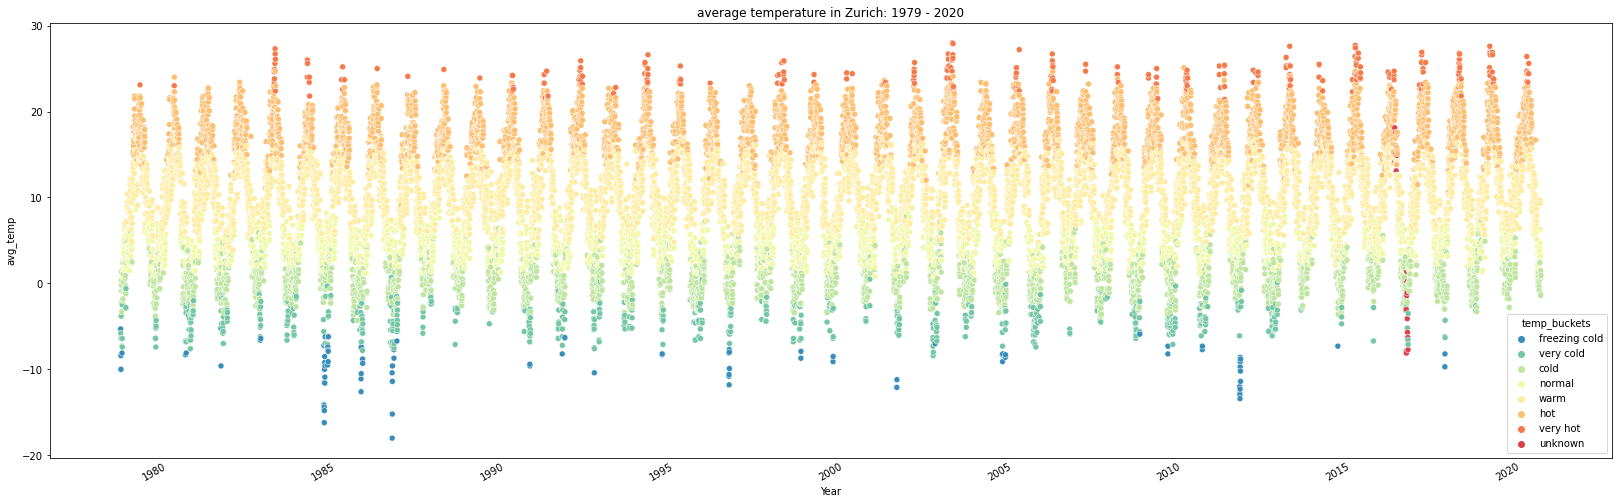

In [117]:
mindate = str(df["date"].min().year)
maxdate = str(df["date"].max().year)

fig, ax = plt.subplots(figsize=(28,8))
sns.scatterplot(hue="temp_buckets", y="avg_temp", x="date", data=df, palette="Spectral_r")

# plot formatting 
ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
ax.set_title("average temperature in Zurich: " + mindate + " - " + maxdate)
plt.xlabel("Year")

plt.show()

Text(0.5, 1.0, 'min - max temperature seperated by month')

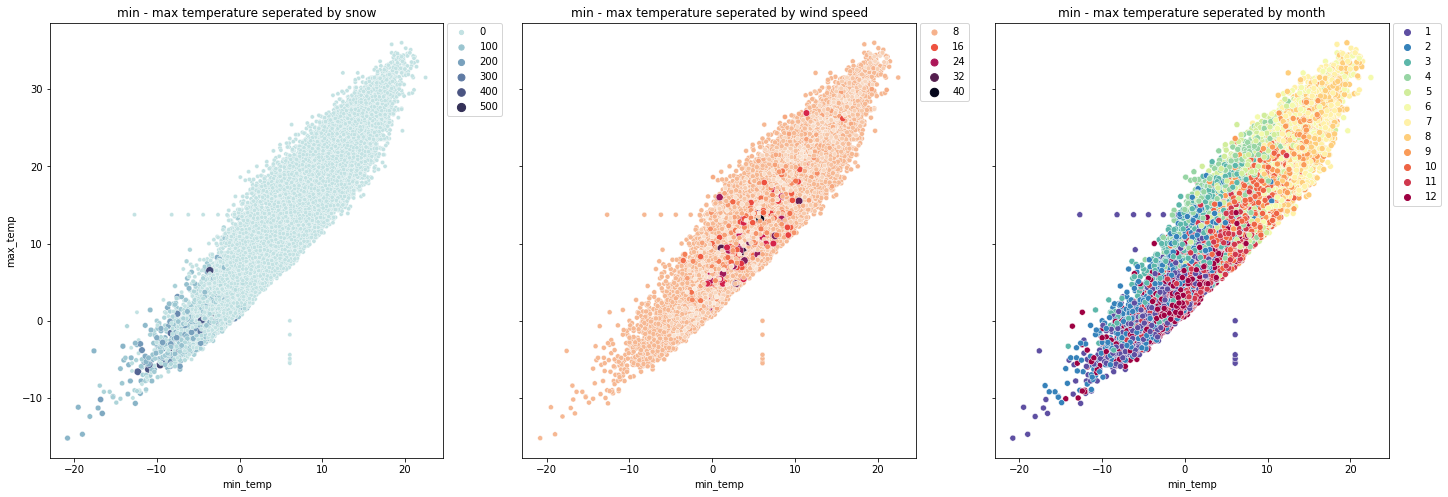

In [118]:
fig, axes= plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(24, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.2)

palette = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)
sns.scatterplot(ax = axes[0], hue="snow", size="snow", y="max_temp", x="min_temp", data=df, alpha=1.0, palette=palette)
axes[0].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[0].set_title("min - max temperature seperated by snow")

sns.scatterplot(ax = axes[1], hue="wind_speed", size="wind_speed", y="max_temp", x="min_temp", data=df, alpha=1.0, palette='rocket_r')
axes[1].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[1].set_title("min - max temperature seperated by wind speed")

sns.scatterplot(ax = axes[2], hue="month", y="max_temp", x="min_temp", data=df, alpha=1.0, palette='Spectral_r', hue_norm=(1,12), legend="full")
axes[2].legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
axes[2].set_title("min - max temperature seperated by month")


   year  month  Event_Count
0  1979      5            5
1  1979      6            7
2  1979      7            7
3  1979      8            6
4  1979      9            1


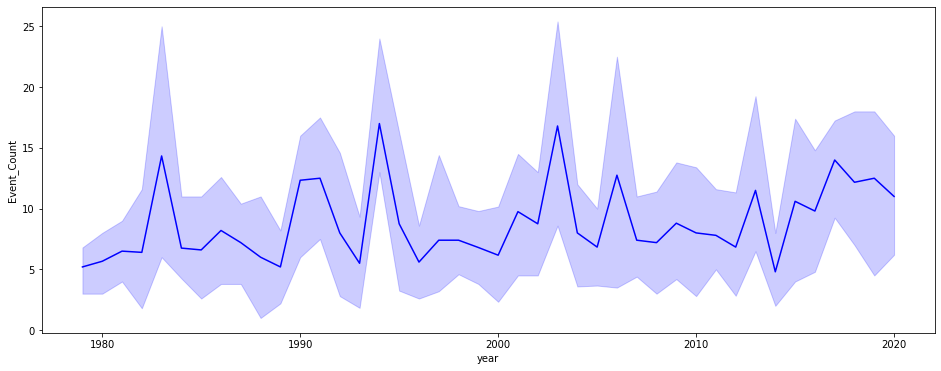

In [131]:
# Data Analysis using PySpark.SQL

# register the dataset as a temp view, so we can use sq
spark_weather_df.createOrReplaceTempView("waeather_data")

# see how event numbers have evolved over years
events_over_years_df = spark.sql( \
        'SELECT year, month, COUNT(*) AS Event_Count \
        FROM waeather_data \
        WHERE max_temp > 25 \
        GROUP BY month, year \
        ORDER BY year, month, Event_Count')
print(events_over_years_df.limit(5).toPandas())

plt.figure(figsize=(16,6))
fig = sns.lineplot(y="Event_Count", x="year", data=events_over_years_df.toPandas(), color= "blue")
plt.show()